# Departamento Médico

### Utilização de Redes Neurais Convolucionais para a classificação de imagens pulmonares em 4 classes:

* Healthy (Saudável)
* Covid - 19
* Pneumonia Bacteriana
* Pneumonia Viral

### Importação das Bibliotecas

In [ ]:
import os
import cv2 
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

### Importação dos Dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Carregando o diretório
raio_x_dir = '/content/drive/MyDrive/Colab Notebooks/Projetos/Departamento médico/Dataset'

In [ ]:
# Verificando 
os.listdir(raio_x_dir)

['.DS_Store', '0', '2', '1', '3']

In [ ]:
# Rescalonando: 0 - 255 --> 0 - 1
imagem = ImageDataGenerator(rescale = 1./255)

### Geração imagens de treinamento
 
* batch_size = Tamanho do lote de imagens.
* shuffle = Embaralha as imagens.
* class_mode = Indica a ordem de classificação (binária, categórica).
* subset = Indica que são imagens para treinamento.

In [ ]:
treino = imagem.flow_from_directory(batch_size = 40, directory = raio_x_dir,
                                    shuffle = True, target_size = (256,256),
                                    class_mode = 'categorical', subset = 'training')

Found 532 images belonging to 4 classes.


In [ ]:
imagens_treino, labels_treino = next(treino)

In [ ]:
# Número do lote, tamanho e canais
imagens_treino.shape

(40, 256, 256, 3)

In [ ]:
# Dicionário com dados
labels = {0: 'Covid-19',
          1: 'Normal',
          2: 'Pneumonia Viral',
          3: 'Pneumonia Bacterial'}

### Visualização dos Dados
* Subplot de 36 imagens 
* Figura de tamanho 12, 12
* Cada imagem possui o título correspondente ao seu label

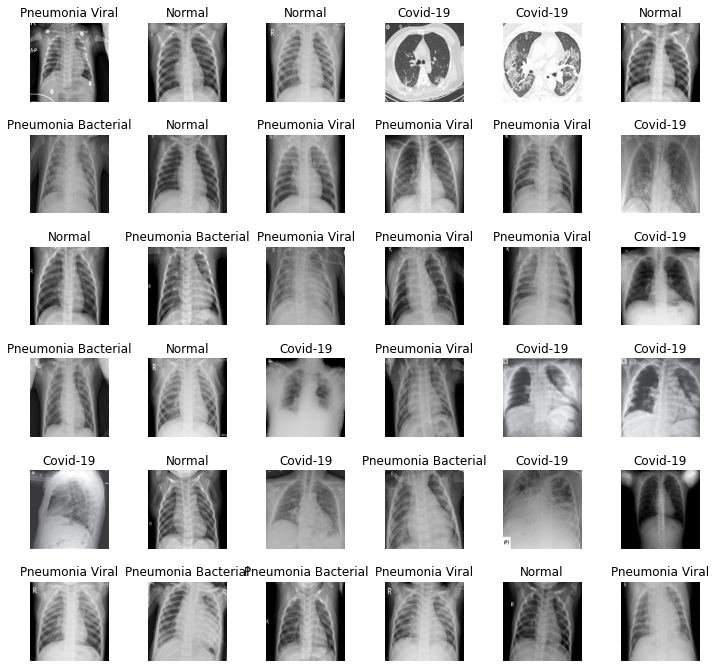

In [ ]:
fig, axes = plt.subplots(6,6, figsize = (12,12))
axes = axes.ravel()
for i in np.arange(0,36):
    axes[i].imshow(imagens_treino[i])
    axes[i].set_title(labels[np.argmax(labels_treino[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

### Redes Neurais Convolucionais

Passos:
* Imagem de Entrada.
* Aplicação de várias camadas de filtros (kernels) para detecção de bordas, bluring etc.
* Downsampling (Pooling com ReLU) para redução de dimensionalidade.
* Flattening (Vetorização) para aí sim entrar em uma Rede Neural.

### ResNet

Rede Convolucional já treinada com 11 milhões de imagens:
* Além de propagar o vetor de peso F(x) para a próxima camada, utiliza o conceito de "skip connection" passando também o dado original x. Assim, no fim a transmissão de informação fica igual a F(x) + x.

### Transfer Learning

Aproveitamento do pré- treino de uma Rede:
* Não é necessário treinar do "zero". 
* Pesos já aprendidos anteriormente.
* Redução de tempo. 
* Usado para tarefas similares.

### Estrutura da Rede

In [ ]:
# Parte já treinada (sem o topo RN)
modelo_base = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256,256,3)))
 

94773248/94765736 [==============================] - 2s 0us/step


In [ ]:
# Camadas
modelo_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Congelando os pesos até as 10 últimas
for layer in modelo_base.layers[:-10]:
    layers.trainable = False

### Construção e treinamento

In [ ]:
# Começa a partir do fim da base
modelo_top = modelo_base.output
modelo_top = AveragePooling2D()(modelo_top)
modelo_top = Flatten()(modelo_top)
modelo_top = Dense(256, activation='relu')(modelo_top)
modelo_top = Dropout(0.2)(modelo_top)
modelo_top = Dense(256, activation='relu')(modelo_top)
modelo_top = Dropout(0.2)(modelo_top)
modelo_top = Dense(4, activation = 'softmax')(modelo_top)

In [ ]:
modelo = Model(inputs = modelo_base.inputs , outputs = modelo_top)

In [ ]:
modelo.compile(loss = 'categorical_crossentropy',
               optimizer = optimizers.RMSprop(lr = 1e-4, decay = 1e-6),
               metrics = ['accuracy']
               )

In [ ]:
# Vai salvando o modelo
checkpointer = ModelCheckpoint(filepath = 'weigths.hdf5')

In [ ]:
# Batch size com 4
treino = imagem.flow_from_directory(batch_size = 4, directory = raio_x_dir,
                                    shuffle = True, target_size = (256,256),
                                    class_mode = 'categorical', subset = 'training')

Found 532 images belonging to 4 classes.


In [ ]:
# Histórico do treinamento
historico = modelo.fit_generator(treino, epochs = 25, callbacks = [checkpointer])

In [ ]:
historico.history.keys()

dict_keys(['loss', 'accuracy'])

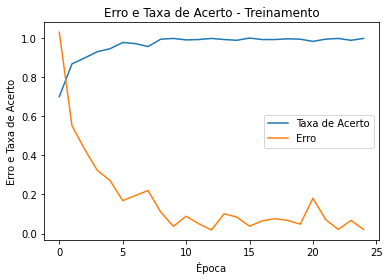

In [ ]:
# Plot do historico
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['loss'])
plt.title('Erro e Taxa de Acerto - Treinamento')
plt.xlabel('Época')
plt.ylabel('Erro e Taxa de Acerto')
plt.legend(['Taxa de Acerto', 'Erro']);

### Teste

In [ ]:
# Carregamento do diretorio com imagens de teste
diretorio_teste = '/content/drive/MyDrive/Colab Notebooks/Projetos/Departamento médico/Test'

In [ ]:
# Normalização e batch
teste = ImageDataGenerator(rescale=1./255)
teste = teste.flow_from_directory(batch_size = 40, directory = diretorio_teste,
                                  shuffle = True, target_size = (256,256),
                                  class_mode = 'categorical')

Found 40 images belonging to 4 classes.


In [ ]:
# Avaliação
avaliar = modelo.evaluate_generator(teste)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [ ]:
avaliar

[4.288605690002441, 0.75]

In [ ]:
# Processo de adequação da imagem ao Tf
predicao = []
original = []
imagem = []

for i in range(len(os.listdir(diretorio_teste))):
    for item in os.listdir(os.path.join(diretorio_teste, str(i))):
        img = cv2.imread(os.path.join(diretorio_teste, str(i), item))
        img = cv2.resize(img, (256, 256))
        imagem.append(img)
        img = img/255
        img = img.reshape(-1,256,256,3)
        predito = modelo.predict(img)
        predito = np.argmax(predito)
        predicao.append(predito)
        original.append(i)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [ ]:
# Obtendo a acurácia
accuracy_score(original, predicao)

0.725

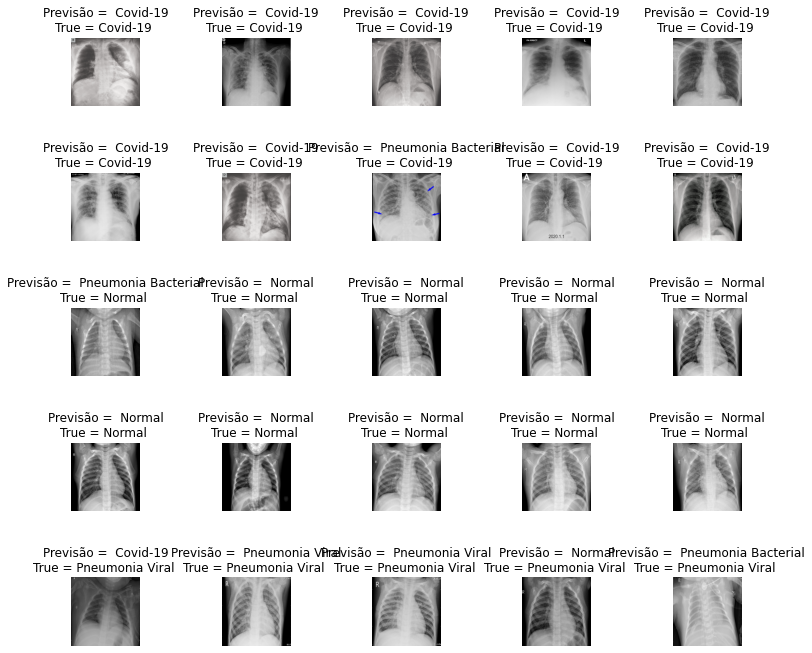

In [ ]:
# Plotando as imagens com os labels e com as predições
fig, axes = plt.subplots(5,5, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0,25):
    axes[i].imshow(imagem[i])
    axes[i].set_title('Previsão =  {}\nTrue = {} '.format(str(labels[predicao[i]]),str(labels[original[i]])))
    axes[i].axis('off')
plt.subplots_adjust(wspace=1.2)    

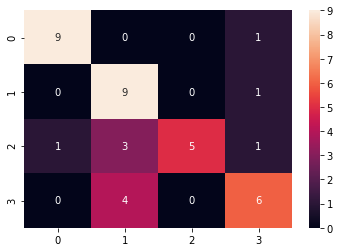

In [ ]:
# Matriz de Confusão
cm = confusion_matrix(original, predicao)
sns.heatmap(cm, annot=True)

In [ ]:
print(classification_report(original, predicao))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.56      0.90      0.69        10
           2       1.00      0.50      0.67        10
           3       0.67      0.60      0.63        10

    accuracy                           0.73        40
   macro avg       0.78      0.72      0.72        40
weighted avg       0.78      0.72      0.72        40



### Classificação de somente uma imagem

In [ ]:
# Carregando o modelo
from keras.models import load_model
modelo_carregado = load_model('/content/weigths.hdf5')

In [ ]:
# Sumário 
modelo_carregado.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# Carregando uma imagem aleatória
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Projetos/Departamento médico/Test/0/nejmoa2001191_f4.jpeg')

In [ ]:
# Imagem fora do padrão (256,256)
img.shape

(1439, 1800, 3)

In [ ]:
# Visualizando a imagem
from google.colab.patches import cv2_imshow
cv2_imshow(img)

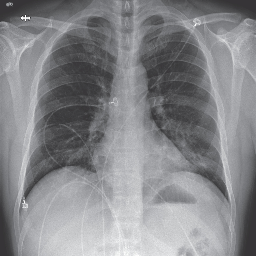

In [ ]:
# Redimensionando
img = cv2.resize(img, (256,256))
cv2_imshow(img)

In [ ]:
# Normalização
img = img/255
img.shape

(256, 256, 3)

In [ ]:
# Colocando no formato de batch
img  = img.reshape(-1,256,256,3)

In [ ]:
# Predicao
predicao = modelo_carregado(img)
predicao = np.argmax(predicao)
labels[predicao]

'Covid-19'